## MONICA Crop Model

--------------

Tasks:

* Скачать погоду в формате MONICA и передать для запуска моделей Sarima, Arima, etc

* Сделать запуск из docker модели

In [1]:
import os, sys
import json
import pandas as pd
import datetime as dt
import subprocess
# import xarray as xr
import math
import shutil


import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
def csvdate_to_date(x, dateformat):
    """Converts string x to a datetime.date using given format.

    :param x: the string representing a date
    :param dateformat: a strptime() accepted date format
    :return: a date
    """
    dt_f = dt.datetime.strptime(str(x), dateformat)
    dt_p = dt.datetime.strftime(dt_f, '%d.%m.%Y')
    return dt_p


# Conversion functions
def NoConversion(x, d):
    return float(x)


def kJ_to_MJ(x, d):
    return float(x)/1000.


def mm_to_cm(x, d):
    return float(x)/10.


def kPa_to_hPa(x, d):
    return float(x)*10.


In [ ]:
nasa_weather = NASA_MONICA(latitude = 45, longitude = 37)

In [20]:
import datetime as dt
import numpy as np 
import os
import requests



In [21]:
lon, lat = 37.793500,51.907430
nasa_weather = NASA_MONICA(latitude = lat, longitude = lon)
df_weather = nasa_weather.df_monica.copy()
df_weather.loc[:,'de-date'] = pd.to_datetime(df_weather.loc[:,'de-date'],
                                             format='%d.%m.%Y')
r = pd.date_range(start=df_weather.loc[:,'de-date'].min(), 
                  end=df_weather.loc[:,'de-date'].max())
df_weather = df_weather.set_index('de-date')
full_range_weather = df_weather.reindex(r).rename_axis('de-date').reset_index()
filled_weather = full_range_weather.fillna(method='ffill', axis=0)      
filled_weather.loc[:, 'de-date'] = filled_weather.loc[:, 'de-date'].dt.strftime('%d.%m.%Y')

fname = './data/monica_weather.csv'
# filled_weather.to_csv(fname, sep=';',index=False)

In [23]:
filled_weather.to_csv(fname, sep=';',index=False)

In [ ]:
cropsDict = {'barley':{'species':'crops/barley.json', 
                       'cultivar':'crops/barley/spring-barley.json',
                       'crop-residues':'crop-residues/barley.json'},
            'soybean':{'species':'crops/soybean.json', 
                       'cultivar':'crops/soybean/000.json',
                       'crop-residues':'crop-residues/soybean.json'},
            'maize':{'species':'crops/maize.json', 
                     'cultivar':'crops/maize/grain-maize-Pioneer-30K75.json',
                     'crop-residues':'crop-residues/maize.json'},
            'wheat':{'species':'crops/wheat.json',
                     'cultivar':'crops/wheat/spring-wheat.json',
                     'crop-residues':'crop-residues/wheat.json'},
            'sugar-beet':{'species':'crops/sugar-beet.json',
                     'cultivar':'crops/sugar-beet/.json',
                     'crop-residues':'crop-residues/beet.json'}}




# calendar datasets
pathCalendar = '/home/mgasanov/agro/CropCalendar'



def prepareCrop(path:str, 
                crop_name:str,
                planting:str,
                harvest:str)-> dict:
    
    """
    Prepare crop dict for MONICA JSON file 
    
    """
    
    
    crop_file = os.path.join(path, 'crop.json')

    with open(crop_file, 'r') as j:
         cropJson = json.loads(j.read())

    #planting date
    cropJson['cropRotation'][0]['worksteps'][0]['date'] = planting
    # harvest date
    cropJson['cropRotation'][0]['worksteps'][1]['date'] = harvest
    for target in ['species', 'cultivar']:
        cropJson['cropRotation'][0]['worksteps'][0]['crop']\
                        ['cropParams'][target][1] = cropsDict[crop_name][target]
    cropJson['cropRotation'][0]['worksteps'][0]['crop']['residueParams'][1] = cropsDict[crop_name]['crop-residues']
    
    cropfName = os.path.join(path, 'crop-monica.json')
    with open(cropfName, 'w') as file: 
        json.dump(cropJson, file, ensure_ascii=False, indent=4)

    
    return cropJson

In [16]:

crop_calendar = {"sugar_beat_2015" : {"crop_start_date": "2015-05-20",
                   "crop_end_date": "2015-09-15"},
                "winter_wheat_2015": {"crop_start_date": "2015-09-25",
                   "crop_end_date": "2016-07-04"},
                "sugar_beat_2017" : {"crop_start_date": "2017-05-20",
                   "crop_end_date": "2017-09-15"},
                "winter_wheat_2017" : {"crop_start_date": "2017-09-25",
                   "crop_end_date": "2018-07-04"}}

 ## Run monica

In [48]:
reanalysis = pd.read_csv('./monica/climate-monica.csv', sep=';')

In [59]:
reanalysis = reanalysis.iloc[365*5+1:-365*4-150, :]

In [139]:
reanalysis.to_csv('./monica/climate-monica_v1.csv', sep=';', index=False)

In [71]:
forecast = pd.read_csv('./prediction_monica.csv')

In [92]:
reanalysis = reanalysis.reset_index(drop=True)

In [87]:
forecast = pd.read_csv('./prediction_monica.csv')

forecast['de-date'] = pd.to_datetime(forecast['de-date'])
mask = forecast['de-date']<'31.12.2017'
forecast = forecast.loc[mask]
forecast['de-date'] = pd.to_datetime(forecast['de-date']).dt.strftime('%d.%m.%Y')

forecast['relhumid'][forecast['relhumid']>0]=99.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [140]:
forecast.round(2).to_csv('./monica/forecast.csv', sep=';', index=False)

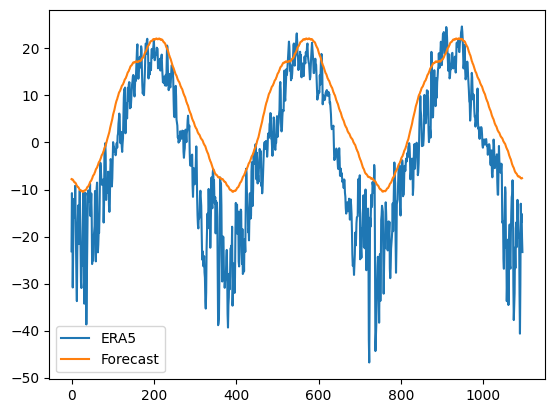

In [138]:
reanalysis['tavg'].plot(label = 'ERA5')
forecast['tavg'].plot(label='Forecast')
plt.legend()

### Run MONICA model 

In [141]:


def run_monica(climate_fname: str)->pd.DataFrame:
    """
    run monica model 
    
    climate_fname: str - path to file with weather
    """
    path_monica = './monica/monica_input/'
    dst = os.path.join(path_monica, "climate-monica.csv")
    shutil.copy2(climate_fname,dst)
    path_sim_file = '/home/monica/monica_input/sim-monica.json'
    cmd = 'monica-run'
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    daily_monica = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    final_monica = pd.read_csv('./out.csv', skiprows=1100, skipfooter=13, engine='python')
    return out_monica, final_monica

In [142]:
df_forecast, final_forecast = run_monica(climate_fname='./monica/forecast.csv')
df_reanalysis, final_reanalysis = run_monica(climate_fname='./monica/climate-monica_v1.csv')

In [147]:
final_forecast

,CM-count,Crop,Yield,sowing,harvest
0,[],[],[kgDM ha-1],[],[]
1,1,soybean/000,4803.4,2016-04-15,2016-09-10
2,2,sugar beet/,29819.6,2017-05-02,2017-11-01


In [148]:
final_reanalysis

,,,,crop
CM-count,Crop,Yield,sowing,harvest
[],[],[kgDM ha-1],[],[]
1,soybean/000,75.7,2016-04-15,2016-09-10
2,sugar beet/,11435.9,2017-05-02,2017-11-01


In [122]:
soybean = df_forecast.loc[df_forecast['Crop']=='soybean/000']

<AxesSubplot:>

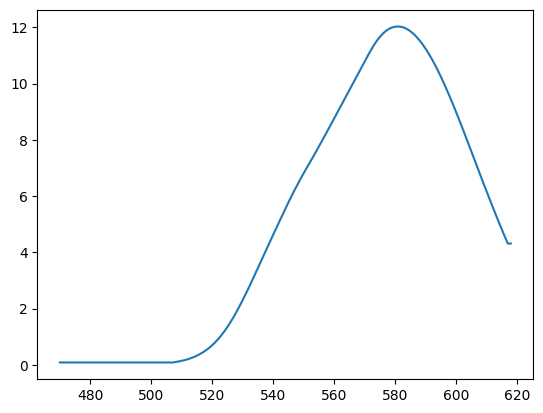

In [124]:
soybean['LAI'].plot()

In [102]:
out_monica

,Date,Crop,TraDef,Tra,NDef,HeatRed,FrostRed,OxRed,Stage,TempSum,...,NEE,Rh,Tmin,Tavg,Tmax,Wind,Globrad,Relhumid,Sunhours,NFert
0,2015-01-01,NaN,0,0.0,0.0,0,0,0,0,0.0,...,6.32388,6.32388,-11.10,-7.80,-4.63,3.58,2.96,99.99,0,0.0
1,2015-01-02,NaN,0,0.0,0.0,0,0,0,0,0.0,...,5.63131,5.63131,-11.20,-7.89,-4.73,3.53,3.09,99.99,0,0.0
2,2015-01-03,NaN,0,0.0,0.0,0,0,0,0,0.0,...,5.36260,5.36260,-11.27,-7.85,-4.66,3.50,3.15,99.99,0,0.0
3,2015-01-04,NaN,0,0.0,0.0,0,0,0,0,0.0,...,5.12300,5.12300,-11.31,-7.88,-4.73,3.47,3.23,99.99,0,0.0
4,2015-01-05,NaN,0,0.0,0.0,0,0,0,0,0.0,...,4.90583,4.90583,-11.43,-8.00,-4.73,3.44,3.14,99.99,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,2017-12-15,NaN,0,0.0,0.0,0,0,0,0,0.0,...,7.51032,7.51032,-9.56,-6.52,-3.16,3.56,2.93,99.99,0,0.0
1080,2017-12-16,NaN,0,0.0,0.0,0,0,0,0,0.0,...,7.37928,7.37928,-9.72,-6.55,-3.16,3.56,2.88,99.99,0,0.0
1081,2017-12-17,NaN,0,0.0,0.0,0,0,0,0,0.0,...,7.25274,7.25274,-9.83,-6.65,-3.29,3.55,2.85,99.99,0,0.0
1082,2017-12-18,NaN,0,0.0,0.0,0,0,0,0,0.0,...,7.12761,7.12761,-10.00,-6.81,-3.32,3.56,2.65,99.99,0,0.0


In [33]:
mask = out_monica['Crop']=='wheat/winter wheat'

In [36]:
wheat = out_monica.loc[mask]

<AxesSubplot:xlabel='Date'>

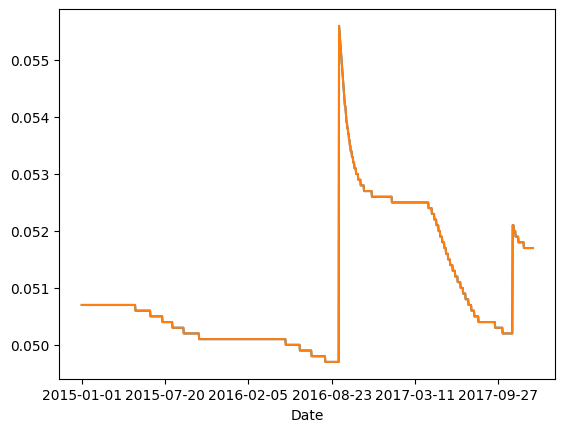

In [153]:
df_forecast.set_index('Date')['SOC_1'].plot()
df_reanalysis.set_index('Date')['SOC_1'].plot()

## Meteo analytics

In [154]:
reanalysis.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


tavg        -2.585867
tmin        -7.315885
tmax         1.672181
wind         0.329489
globrad     10.560055
precip       1.438020
relhumid    87.867810
dtype: float64

In [155]:
forecast.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


tavg         6.316152
tmin         1.522118
tmax        11.332403
wind         2.994043
globrad     12.638206
precip       1.337503
relhumid    99.990000
dtype: float64